In [34]:
import sqlite3
import pandas as pd
import geopandas as gpd
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import segregation
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local, Moran

## Agglomerative Clustering

In [56]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [59]:
outfile = "../data/intra_urban_completeness_stats.csv"
stats_df = pd.read_csv(outfile)
stats_df.drop(
    ["Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True
)
    
n_clusters = 5
columns = [
    "osm_completeness",
    "gini",
    "moran"
]

stats_df_cluster = stats_df.dropna()
X = stats_df_cluster[columns].values

# cluster = KMeans(n_clusters=n_clusters).fit(X)
cluster = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
stats_df_cluster["label"] = cluster.labels_

display(cluster.labels_)
display(stats_df_cluster["label"].value_counts())
display(stats_df_cluster)

array([3, 0, 4, ..., 3, 3, 0])

0    1937
3     953
2     745
1     580
4     376
Name: label, dtype: int64

,urban_center_id,osm_completeness,gini,moran,spatial_proximity,label
0,6114,0.062,0.829,0.591,1.001,3
1,11233,0.001,0.966,-0.041,1.000,0
2,273,0.553,0.867,0.602,1.004,4
3,3936,0.001,0.820,0.040,1.000,0
4,12502,0.009,0.934,-0.055,1.000,0
...,...,...,...,...,...,...
4744,11366,0.470,0.698,0.338,1.002,1
4745,536,0.200,0.784,0.033,1.000,0
4746,55,0.091,0.851,0.239,1.000,3
4747,9180,0.095,0.828,0.549,1.003,3


### Find/Decide Cluster Representatives by calculation center for each cluster

In [54]:
def calc_distance(row, cluster_center):
    distance = math.dist(
        cluster_center,
        [
            row["osm_completeness"],
            row["gini"],
            row["moran"]
        ]
    )
    return distance


def load_urban_centers_with_name():
    """Load urban center grids for given urban center id."""
    con = sqlite3.connect("../data/global_urban_building_completeness.gpkg")
    query = f"""
        select 
          urban_center_id,
          name_main,
          iso_a3,
          ghspop / 1000000 as ghspop
        from rf_adjusted_prediction_reference_and_osm_urban_centers a
        group by urban_center_id
    """
    df = pd.read_sql_query(query, con=con)
    return df


cluster_labels = [
    0, 3, 1, 4,  2
]

urban_centers_df = load_urban_centers_with_name().set_index("urban_center_id")

for i, label in enumerate(cluster_labels):
    
    print(label, title_labels[i])
    cluster_df = stats_df_cluster.loc[stats_df_cluster["label"] == cluster_labels[i]]
    cluster_center = [
        cluster_df["osm_completeness"].mean(),
        cluster_df["gini"].mean(),
        cluster_df["moran"].mean()
    ]
    
    cluster_df["distance"] = cluster_df.apply(lambda row: calc_distance(row, cluster_center),axis=1)  
    cluster_df.set_index("urban_center_id", inplace=True)
    
    cluster_df = cluster_df.join(urban_centers_df)
    
    display(
        cluster_df.loc[cluster_df["ghspop"]>0.5].sort_values(by="distance", ascending=True)[0:10]
    )

0 cluster (a)


,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,osm_completeness,gini,moran,spatial_proximity,label,distance,name_main,iso_a3,ghspop
urban_center_id,,,,,,,,,,,,
11375,1388,1388,1388,0.043,0.820,0.064,1.0,0,0.012925,Tai'an,CHN,0.707875
5166,2968,2968,2968,0.036,0.796,0.072,1.0,0,0.014019,Nampula,MOZ,0.698424
8045,2202,2202,2202,0.032,0.815,0.061,1.0,0,0.014769,Rae Bareli,IND,0.792939
11147,4019,4019,4019,0.042,0.801,0.054,1.0,0,0.016082,Pingdingshan,CHN,0.802936
6779,1691,1691,1691,0.027,0.809,0.077,1.0,0,0.017742,Vadodara,IND,2.112114
11469,1095,1095,1095,0.043,0.827,0.066,1.0,0,0.019272,Liaoyang,CHN,0.618062
6637,3123,3123,3123,0.018,0.821,0.075,1.0,0,0.028567,Jodhpur,IND,1.308233
4483,2629,2629,2629,0.023,0.786,0.055,1.0,0,0.032315,Wad Madanī,SDN,0.545968
4096,2536,2536,2536,0.033,0.821,0.098,1.0,0,0.033645,Al Ismailiya,EGY,0.599918


3 cluster (b)


,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,osm_completeness,gini,moran,spatial_proximity,label,distance,name_main,iso_a3,ghspop
urban_center_id,,,,,,,,,,,,
11202,1206,1206,1206,0.155,0.798,0.399,1.001,3,0.015053,Qinhuangdao,CHN,0.780184
234,1938,1938,1938,0.137,0.814,0.420,1.002,3,0.034649,Nuevo Laredo,MEX,0.601744
3601,910,910,910,0.152,0.836,0.400,1.004,3,0.039104,Bursa,TUR,1.682410
143,4214,4214,4214,0.168,0.832,0.390,1.001,3,0.040787,Ciudad Juárez,MEX,1.763650
12500,465,465,465,0.116,0.778,0.368,1.000,3,0.040858,Pati,IDN,1.598273
11280,3888,3888,3888,0.136,0.831,0.415,1.001,3,0.041472,Jinan,CHN,3.484923
8502,3154,3154,3154,0.130,0.796,0.350,1.001,3,0.041709,Tiruchirappalli,IND,1.266364
3684,1120,1120,1120,0.127,0.807,0.429,1.001,3,0.043698,Johannesburg,ZAF,6.516242
12795,1238,1238,1238,0.115,0.835,0.389,1.001,3,0.045690,Kitakyushu,JPN,1.202967


1 cluster (c)


,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,osm_completeness,gini,moran,spatial_proximity,label,distance,name_main,iso_a3,ghspop
urban_center_id,,,,,,,,,,,,
4098,3708,3708,3708,0.606,0.623,0.362,1.001,1,0.059904,Donetsk,UKR,0.996412
12450,3033,3033,3033,0.591,0.601,0.392,1.002,1,0.075592,Magelang,IDN,0.675294
4939,438,438,438,0.490,0.569,0.323,1.001,1,0.084187,Tbilisi,GEO,1.077588
3593,4394,4394,4394,0.572,0.687,0.357,1.002,1,0.087764,Odesa,UKR,1.117736
3781,275,275,275,0.537,0.661,0.402,1.001,1,0.101012,Zaporizhzhia,UKR,0.730151
5088,1807,1807,1807,0.578,0.504,0.316,1.000,1,0.104085,Astrakhan,RUS,0.540260
10181,837,837,837,0.519,0.514,0.332,1.000,1,0.104446,Lanzhou,CHN,2.364579
11914,4496,4496,4496,0.572,0.525,0.393,1.001,1,0.109271,Weihai,CHN,0.606531
13077,4124,4124,4124,0.554,0.580,0.434,1.001,1,0.116471,Davao City,PHL,0.821502


4 cluster (d)


,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,osm_completeness,gini,moran,spatial_proximity,label,distance,name_main,iso_a3,ghspop
urban_center_id,,,,,,,,,,,,
557,966,966,966,0.546,0.859,0.618,1.005,4,0.040120,Minneapolis [Saint Paul],USA,1.740849
3810,1139,1139,1139,0.601,0.857,0.650,1.002,4,0.052414,Lusaka,ZMB,2.365977
273,2,2,2,0.553,0.867,0.602,1.004,4,0.056125,Denver,USA,2.230488
8572,3245,3245,3245,0.559,0.826,0.706,1.004,4,0.061420,Waidhan,IND,0.541968
1079,2798,2798,2798,0.609,0.797,0.644,1.002,4,0.063025,Asuncion,PRY,1.967896
8251,3139,3139,3139,0.588,0.815,0.698,1.006,4,0.064106,Prayagraj,IND,2.693705
193,949,949,949,0.498,0.829,0.677,1.005,4,0.066214,Salt Lake City,USA,0.972676
1919,2756,2756,2756,0.540,0.782,0.598,1.004,4,0.069534,London,GBR,9.609566
3740,3368,3368,3368,0.549,0.761,0.647,1.003,4,0.070238,Antalya,TUR,0.948077


2 cluster (e)


,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,osm_completeness,gini,moran,spatial_proximity,label,distance,name_main,iso_a3,ghspop
urban_center_id,,,,,,,,,,,,
2455,171,171,171,0.906,0.667,0.151,1.0,2,0.023877,Frankfurt am Main,DEU,0.958558
3255,3435,3435,3435,0.929,0.680,0.153,1.0,2,0.031656,Helsinki,FIN,0.906727
2378,1004,1004,1004,0.910,0.636,0.131,1.0,2,0.047264,Nice,FRA,0.734837
2195,4365,4365,4365,0.950,0.681,0.163,1.0,2,0.054454,Lyon,FRA,1.152257
3362,1274,1274,1274,0.903,0.705,0.083,1.0,2,0.054912,Lviv,UKR,0.687138
1649,3839,3839,3839,0.906,0.684,0.075,1.0,2,0.058272,Bouaké,CIV,0.524045
2897,962,962,962,0.957,0.694,0.108,1.0,2,0.059360,Dresden,DEU,0.513467
2054,26,26,26,0.951,0.678,0.179,1.0,2,0.065467,Paris,FRA,9.712652
2327,2242,2242,2242,0.963,0.705,0.157,1.0,2,0.066959,Wuppertal,DEU,0.604729


The following urban centers have been selected:
* "A - San Miguel de Tucumán",
* "B - Johannesburg",
* "C - Tbilisi",
* "D - Minneapolis",
* "E - Paris", 

### Plot Scatterplots (for Figure 5)

,urban_center_id,osm_completeness,gini,moran,spatial_proximity,label
2784,996,0.032,0.779,0.053,1.0,0


,urban_center_id,osm_completeness,gini,moran,spatial_proximity,label
1120,3684,0.127,0.807,0.429,1.001,3


,urban_center_id,osm_completeness,gini,moran,spatial_proximity,label
438,4939,0.49,0.569,0.323,1.001,1


,urban_center_id,osm_completeness,gini,moran,spatial_proximity,label
966,557,0.546,0.859,0.618,1.005,4


,urban_center_id,osm_completeness,gini,moran,spatial_proximity,label
26,2054,0.951,0.678,0.179,1.0,2


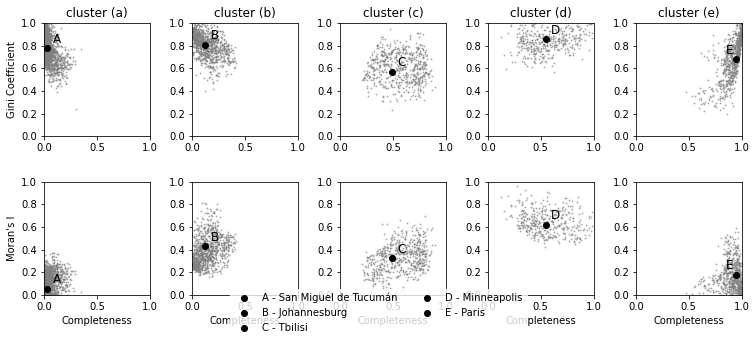

In [61]:
urban_center_ids_selection = [
    996, # San Miguel de Tucumán
    3684, # Johannesburg
    4939,  # Tbilisi
    557,  # Minneapolis
    2054  # Paris
]    

colors = [
    "green",
    "blue",
    "black",
    "orange",
    "violet",
    "red"
]

title_labels = [
    "cluster (a)", "cluster (b)", "cluster (c)", "cluster (d)", "cluster (e)"
]

cluster_labels = [
    0, 3, 1, 4,  2
]


point_labels_names = [
    "A - San Miguel de Tucumán",
    "B - Johannesburg",
    "C - Tbilisi",
    "D - Minneapolis",
    "E - Paris",
]

point_labels = [
    "A",
    "B",
    "C",
    "D",
    "E",
]
size= 12

fig, axs = plt.subplots(2, n_clusters, figsize=(12.5, 5))
gs1 = gridspec.GridSpec(2, n_clusters)
gs1.update(wspace=0.4, hspace=0.4) # set the spacing between axes.

all_handles = []
all_labels = []

for i in range(0, n_clusters):
    # ax = plt.subplot(gs1[3*i])
    ax = plt.subplot(gs1[i])
    cluster_df = stats_df_cluster.loc[stats_df_cluster["label"] == cluster_labels[i]]

    cluster_df_selection = cluster_df.loc[cluster_df["urban_center_id"].isin(urban_center_ids_selection)]
    
    display(cluster_df_selection)
    
    ax.scatter(
        cluster_df["osm_completeness"],
        cluster_df["gini"],
        #color=colors[i],
        color="grey",
        s=1,
        alpha=0.5
    )
    
    ax.scatter(
        cluster_df_selection["osm_completeness"],
        cluster_df_selection["gini"],
        #color=colors[i],
        color="black",
        alpha=1,
        label=point_labels_names[i]
    )
    
    
    if cluster_df_selection["osm_completeness"].to_list()[0] > 0.9:
        ax.annotate(
            point_labels[i],
            (cluster_df_selection["osm_completeness"].to_list()[0] - 0.1,
             cluster_df_selection["gini"].to_list()[0] + 0.05),
            fontsize=size
        ) 
    else:
        ax.annotate(
            point_labels[i],
            (cluster_df_selection["osm_completeness"].to_list()[0] + 0.05,
             cluster_df_selection["gini"].to_list()[0] + 0.05),
            fontsize=size
        )
    
    
    # ax.set_xlabel("Completeness")
    if i == 0:
        ax.set_ylabel("Gini Coefficient")
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    ax.set_title(title_labels[i])
    #ax.grid()
    
    # ax = plt.subplot(gs1[1 + 3*i])
    ax = plt.subplot(gs1[i + n_clusters])
    ax.scatter(
        cluster_df["osm_completeness"],
        cluster_df["moran"],
        #color=colors[i],
        color="grey",
        s=1,
        alpha=0.5
    )
    
    
    if cluster_df_selection["osm_completeness"].to_list()[0] > 0.9:
        ax.annotate(
            point_labels[i],
            (cluster_df_selection["osm_completeness"].to_list()[0] - 0.1,
             cluster_df_selection["moran"].to_list()[0] + 0.05),
            fontsize=size
        )
        ax.scatter(
            cluster_df_selection["osm_completeness"],
            cluster_df_selection["moran"].to_list()[0],
            #color=colors[i],
            color="black",
            alpha=1,
            label=point_labels_names[i]
        )
    else:
        ax.scatter(
            cluster_df_selection["osm_completeness"],
            cluster_df_selection["moran"],
            #color=colors[i],
            color="black",
            alpha=1,
            label=point_labels_names[i]
        )
        ax.annotate(
            point_labels[i],
            (cluster_df_selection["osm_completeness"].to_list()[0] + 0.05,
             cluster_df_selection["moran"].to_list()[0] + 0.05),
            fontsize=size
        )
    
   
    
    ax.set_xlabel("Completeness")
    if i == 0:
        ax.set_ylabel("Moran's I")
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    #ax.grid()

    handles, labels = ax.get_legend_handles_labels()
    all_handles.append(handles[0])
    all_labels.append(labels[0])
    
fig.legend(
    all_handles,
    all_labels,
    loc='lower center',
    ncol=2,
    edgecolor="white"
)    

plt.savefig(
    "../figures/intra_urban_completeness_clustering_plot.png",
    dpi=300,
    bbox_inches = 'tight',
    pad_inches = 0.75
)
plt.show()

### Plot Cluster Dendogram (for Figure 6)

[4232 4526 3074 ...    6    2    0]


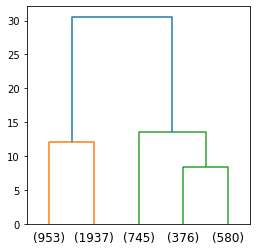

[4232 4526 3074 ...    6    2    0]


In [57]:
def run_clustering_full(X):
    cluster = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=0
    )
    cluster.fit(X)
    
    print(cluster.labels_)
    return cluster


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

cluster2 = run_clustering_full(X)

plt.figure(figsize=(4,4))
# plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(
    cluster2,
    truncate_mode='lastp',
    p=5,
)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig(
    "../figures/intra_urban_completeness_cluster_dendrogram.png",
    dpi=300,
    bbox_inches = 'tight'
)
plt.show()


print(cluster2.labels_)